In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import loggamma
from scipy.optimize import minimize

## MAP estimation

We'll calculate the MAP estimate for the Binomial data we illustrated in Figure 5.2 . We have data from a series of Bernoulli trials. The likelihood only depends on the number of trials, the number of successes (number of heads for the example in Figure 5.2), and the success probability $p$. We'll use scipy's in-built optimization algorithms to maximize the posterior. We do this by minimizing the negative of the log-posterior. We only need to calculate the sum of the log-likelihood and the log-prior, since we can drop the normalizing constant from the log-posterior, as this does not depend upon the success probability. The parameter we maximize the log-posterior with respect to will actually be the logit of the success probability.

First we'll define some functions to construct a callable python function that returns the negative log-posterior (up to a global constant).

In [2]:
def get_neg_log_binomial_posterior(n_trial, n_success, alpha, beta):
    '''
    A function to construct a callable that returns the negative of the 
    log-posterior for binomially distributed data, with a Beta 
    prior for the success probability of the Bernoulli trials. 
    
    :param n_trial: The number of Bernoulli trials.
    :type n_trial: int
    
    :param n_success: The number of successes.
    :type n_success: int
    
    :param alpha: The alpha parameter of the Beta prior.
    :type alpha: float
    
    :param beta: The beta parameter of the Beta prior.
    :type beta: float
    
    :return: A callable that returns the negative of the log-posterior 
             (up to a global constant) and takes the logit of the success
             probability logit(p) as input.
    :rtype: A callable
    '''
    
    def neg_log_binomial_posterior(logit_p):
        '''
        A function to compute the negative log-posterrior (up to a
        global constant) for binomially distributed data, with a Beta 
        prior for the success probability of the Bernoulli trials. 
        
        The function is a function of the logit of the success probability.
        This is so the optimization algorithm can search between -infinity 
        and +infinity and still yield a valid success probability p that is 
        between 0 and 1. If we were to use p instead of logit(p) for our 
        parameter, we would have to perform a constrained optimization to 
        ensure we keep within [0,1]. The logit transformation is a 
        convenient way of doing this.
        
        We return the negative of the log-posterior because we will use 
        scipy's inbuilt minimization algorithms. Recall, maximizing a 
        function is the same as minimizing the negative of the function.
        
        :param logit_p: The logit of the success probability.
        :type logit_p: float
        
        :return: The negative of the sum of the log-likelihood and the
                 the log-prior
        :rtype: float
        '''

        # Compute the success probability p from logit(p)
        p = np.exp(logit_p)/ (1.0 + np.exp(logit_p))
        
        # Compute the log-prior
        log_prior = loggamma(alpha + beta) - loggamma(alpha) - loggamma(beta) 
        log_prior += ((alpha-1.0)*np.log(p)) + ((beta-1.0)*np.log(1.0 - p))
  
        # Compute the log-likelihood
        log_likelihood = loggamma(n_trial + 1.0) - loggamma(n_trial - n_success + 1.0) - loggamma(n_success + 1.0)
        log_likelihood += (n_success*np.log(p)) + ((n_trial-n_success)*np.log(1.0-p))
  
        # Compute the log-posterior, up to the global normalization factor,
        # as the sum of the log prior and log-likelihood
        log_posterior = log_likelihood + log_prior
  
        return -log_posterior

    return neg_log_binomial_posterior
    

Now we'll set the data. In this example we'll use the values from left-hand panel of Figure 5.2 in the main text

In [3]:
# Specify the sample size and the number of successes
n_trial = 10
n_success = 5

# Specify the parameters of the prior
alpha = 8
beta = 2

# Get the objective function to minimized
neg_log_posterior = get_neg_log_binomial_posterior(n_trial, n_success, alpha, beta)

# Construct an initial estimate for the optimal parameter.
# We'll use the sample success proportion to do this (and take the logit)
p0 = float(n_success)/float(n_trial)
logit_p0 = np.log(p0/(1.0-p0))
x0 = np.array([logit_p0])

Now we'll do the minimization of the negative log-posterior using the scipy's implementation of the BFGS (Broyden-Fletcher-Goldfarb-Shanno) algorithm.

In [4]:
# Now minimize the negative log-posterior using trhe BFGS algorithm.
# This uses a variant of gradient descent. It evaluates the gradient via 
# numerical differentiation, we only need to provide the objective function.
# We can, if we want also supply code to evaluate the derivate of the objective 
# function with respect to the parameters we are optimizing if we felt that the
# numerical differentiation was not sufficiently accurate.
map_estimate = minimize(neg_log_posterior, x0, method='BFGS', options={'disp': True})

Optimization terminated successfully.
         Current function value: 1.651160
         Iterations: 5
         Function evaluations: 12
         Gradient evaluations: 6


Let's look at the map estimate value for the parameter 

In [5]:
map_estimate

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.651159822779154
        x: [ 6.931e-01]
      nit: 5
      jac: [-2.980e-08]
 hess_inv: [[ 2.499e-01]]
     nfev: 12
     njev: 6

We'll convert the MAP estimate for logit(p) to an estimate for p. We can see that the MAP estimate for $p$ is not 0.5, i.e. our prior is having a sufficient influence to make us think this is not a fair coin (if we use the MAP estimate).

In [6]:
# Convert from logit(p) to p 
p_optimal = np.exp(map_estimate['x'][0])/ (1.0 + np.exp(map_estimate['x'][0]))
print("MAP estimate of success probability = ", p_optimal)

MAP estimate of success probability =  0.666666667917668


## Basic Metropolis-Hastings MCMC example

We'll code up a very basic version of the Metropolis-Hastings algorithm, and use it to sample $logit(p)$ values from the posterior $P(\log(p/(1-p)) | \mathrm{Data})$. We sample $logit(p)$ values instead of values of $p$ because, for simplicity of this demonstration, we don't want to constrain the space from which our trial parameter values comes. This means we want to work with a parameter that lies in the range $-\infty$ to $\infty$, rather than in $[0,1]$. We do that by sampling $\log(p/(1-p))$. This means we'll need to calculate the posterior for $\log(p/(1-p))$, but we can do this using the rule for transforming probability distributions that we recapped in Chapter 1. Doing so gives $\log P(\log(p(1-p)) | \mathrm{Data}) =  \log P( p | \mathrm{Data}) +\log(p(1-p))$.

First we'll define two functions; one to perform a single trial Metropolis-Hastings move, and one to run the Markov chain for a user-specified number of burn-in iterations followed by a user-specified number of sampling iterations

In [7]:
def perform_mh_trial(x, log_post, delta_x, neg_log_posterior):
    '''
    Function to perform a Metropolis-Hastings trial move
    
    :param x: The current logit(p) value
    :type x: float
    
    :param log_post: The current log-posterior value
    :type log_post: float
    
    :param delta_x: The half-width of the range from which the trial 
                    adjustments to logit(p) are made
    :type delta_x: float
    
    :param neg_log_posterior: A callable that returns the negative of the log-posterior 
                              (up to a global constant) and takes the logit of the success
                              probability logit(p) as input.
    :type neg_log_posterior: A callable
    
    :return: A tuple of the updated current logit(p) value and 
             current log-posterior value
    :rtype: A tuple of floats
    '''
    accept_trial = False
    x_trial = x + (delta_x*(2.0*np.random.rand(1) - 1.0))
    p_trial = np.exp(x_trial)/(1.0 + np.exp(x_trial))
    
    # Calculate the log-posterior for the trial point.
    # Note we'll need to flip the sign of neg_log_posterior, as 
    # our callable returns the negative of the log-posterior.
    log_post_trial = -neg_log_posterior(x_trial) + np.log(p_trial*(1.0-p_trial))
    
    # Calculate the change in log-posterior if we move to the trial point
    delta_log_post = log_post_trial - log_post
        
    # Work out if should accept the trial point
    if delta_log_post > 0.0:
        accept_trial = True
    else:
        if np.log(np.random.rand(1)) < delta_log_post:
            accept_trial = True
            
    # If we accept the trial point then update the current value of the parameter and 
    # the log-posterior
    if accept_trial==True:
        x = x_trial
        log_post = log_post_trial
        
    return x, log_post

def mh_mcmc(n_burnin, n_iter, x0, delta_x, neg_log_posterior):
    '''
    A function to run a simple Metropolis-Hastings MCMC
    calculation.
    
    :param n_burnin: The number of burnin iterations to be run
    :type n_burnin: int
    
    :param n_iter: The number of sampling iterations to be run
    :type n_iter: int
    
    :param x0: The starting value for logit(p)
    :type x0: float

    :param delta_x: The half-width of the range from which the trial 
                    adjustments to logit(p) are made
    :type delta_x: float
    
    :param neg_log_posterior: A callable that returns the negative of the log-posterior 
                              (up to a global constant) and takes the logit of the success
                              probability logit(p) as input.
    :type neg_log_posterior: A callable
    
    :return: An array of the sampled logit(p) values
    :rtype: A 1D numpy array of length n_iter
    '''
    
    #Calculate starting log_posterior
    x = x0
    p0 = np.exp(x0)/(1.0 + np.exp(x0))
    log_post = -neg_log_posterior(x) + np.log(p0*(1.0-p0))
    
    # Run the chain for the specified burn-in length
    for iter in range(n_burnin):
        x, log_post = perform_mh_trial(x, log_post, delta_x, neg_log_posterior)
        
    # Initialize an empty array to hold the sampled parameter values
    x_chain = np.zeros(n_iter)
    
    # Continue the chain for the specified number of sampling points
    # Store the sampled parameter values
    for iter in range(n_iter):
        x, log_post = perform_mh_trial(x, log_post, delta_x, neg_log_posterior)
        x_chain[iter] = x
        
    return x_chain    

Now we'll set the data. Again, in this example we'll use the values from left-hand panel of Figure 5.2 in the main text

In [8]:
# Specify the sample size and the number of successes
n_trial = 10
n_success = 5

# Specify the parameters of the Beta prior
alpha = 8
beta = 2

# Construct a starting point for the MCMC calculation.
# We'll use the sample success proportion to do this (and take the logit)
p0 = float(n_success)/float(n_trial)
logit_p0 = np.log(p0/(1.0-p0))

Now we'll run the MCMC calculation. We'll run a long burn-in period of 20000 iterations to be sure, and then we'll take 1million samples.

In [9]:
# Run the MCMC calculation
x_chain = mh_mcmc(n_burnin=20000, 
                  n_iter=1000000, 
                  x0=logit_p0, 
                  delta_x=0.1, 
                  neg_log_posterior=neg_log_posterior)

We'll convert the sample logit(p) values back to probabilities.

In [10]:
# Convert the MCMC sampled logit(p) values back to values of 
# the success probability
p_mcmc = np.exp(x_chain)/ (1.0 + np.exp(x_chain))

Now we'll define a function to compute the posterior exactly. The Beta distribution is what is called a *conjugate prior*, meaning the posterior takes the same mathematical form as the prior (but with modified parameters). Since we know the mathematical form of the Beta distribution this means we can easily calculate the posterior in closed-form. We'll use the function to compute the true posterior value for a sequence of success probabilities.

In most situations we are aren't so lucky that the posterior can be reduced to a simple formula that can be calculated in closed-form. In this case we can, and so we'll use it to compare how well our simple MCMC algorithm has worked in sampling from the true posterior. If the MCMC algorithm is good, then the sample of parameter values will have a distribution that is close to the true posterior. 

In [11]:
def true_binomial_posterior(n_trial, n_success, alpha, beta, p):
    
    log_posterior = loggamma(n_trial + alpha + beta) - loggamma(n_success + alpha) - loggamma(n_trial - n_success + beta)
    log_posterior += ((n_success + alpha - 1.0)*np.log(p)) + ((n_trial-n_success + beta -1.0)*np.log(1.0-p))
    
    posterior = np.exp(log_posterior)
    
    return posterior

In [12]:
# Calculathe true posterior values for a sequence of 
# success probabilities
p_sequence = np.arange(0.01, 0.99, 0.005)
true_posterior_sequence = np.zeros(p_sequence.shape[0])

for i in range(true_posterior_sequence.shape[0]):
    true_posterior_sequence[i] = true_binomial_posterior(n_trial, n_success, alpha, beta, p_sequence[i])

Now let's look at the histogram of the MCMC sampled success probabilities and compare it to the true posterior curve. The true posterior curve will be the same posterior curve that is shown in the left-hand panel of Figure 5.2 in the main text.

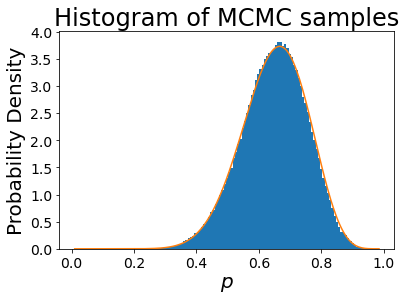

In [13]:
# Plot the histogram of posterior sampled success probabilities
# and overlay the true posterior distribution
hist = plt.hist(p_mcmc, bins=100, density=True)
posterior = plt.plot(p_sequence, true_posterior_sequence)
plt.title('Histogram of MCMC samples', fontsize=24)
plt.xlabel(r'$p$', fontsize=20)
plt.ylabel('Probability Density', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()